In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
#load imdb dataset but only keep the top n words, zero the rest
top_words = 5000
(train_X, train_Y), (test_X, test_Y) = imdb.load_data(num_words=top_words)


#Using Keras utility to truncate / pad the data to a length of 500 for each review
max_words = 500
train_X = pad_sequences(train_X, maxlen=max_words)
test_X = pad_sequences(test_X, maxlen=max_words)

17464789/17464789 [==============================] - 1s 0us/step


In [ ]:
#summarize size
print("Training data: ")
print(train_X.shape)
print(train_Y.shape)
print("Test data: ")
print(test_X.shape)
print(test_Y.shape)

Training data: 
(25000, 500)
(25000,)
Test data: 
(25000, 500)
(25000,)


# Building the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, LeakyReLU, Input, Conv1D, MaxPooling1D, Embedding

Batch size is the amount of samples you will be feed into the RNN at one time, for example you have 20000 samples. You will first send 64, when they're complete, you send another 64.

Epoch is how many rounds of this process you will go through. A single epoch would send all your samples through that you intended. Two epochs would do it twice.

In [ ]:
batch_size = 128
epochs = 15

In [ ]:
learning_rate = 0.005
adam_optimizer = Adam(learning_rate=learning_rate)

In [ ]:
#Define the model architecture
sentiment_model = Sequential()
sentiment_model.add(Embedding(top_words, 32, input_length=max_words))
sentiment_model.add(Dropout(0.2))
sentiment_model.add(Conv1D(32, 3, padding='same', activation='relu'))
sentiment_model.add(MaxPooling1D(pool_size=2, padding='same'))
sentiment_model.add(Dropout(0.3))
sentiment_model.add(Conv1D(64, 3, padding='same', activation='relu'))
sentiment_model.add(LeakyReLU(alpha=0.1))
sentiment_model.add(MaxPooling1D(pool_size=2, padding='same'))
sentiment_model.add(Dropout(0.4))
sentiment_model.add(Conv1D(128, 3, padding='same', activation='relu'))
sentiment_model.add(LeakyReLU(alpha=0.1))
sentiment_model.add(MaxPooling1D(pool_size=2, padding='same'))
sentiment_model.add(Dropout(0.5))
sentiment_model.add(Flatten())
sentiment_model.add(Dense(128, activation='linear'))
sentiment_model.add(LeakyReLU(alpha=0.1))
sentiment_model.add(Dropout(0.5))
#output layer: Single neuron, since we're predicting a single continuous value
sentiment_model.add(Dense(1, activation='sigmoid'))

#compile the model for a regression task
sentiment_model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#model summary to understand its structure
sentiment_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 dropout (Dropout)           (None, 500, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 500, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 32)           0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 64)           6208      
                                                        

In [ ]:
sentiment_train = sentiment_model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X,test_Y))

Epoch 1/15
196/196 [==============================] - 73s 362ms/step - loss: 0.5008 - accuracy: 0.7227 - val_loss: 0.2921 - val_accuracy: 0.8813
Epoch 2/15
196/196 [==============================] - 79s 404ms/step - loss: 0.2814 - accuracy: 0.8867 - val_loss: 0.2736 - val_accuracy: 0.8862
Epoch 3/15
196/196 [==============================] - 70s 357ms/step - loss: 0.2243 - accuracy: 0.9134 - val_loss: 0.2856 - val_accuracy: 0.8769
Epoch 4/15
196/196 [==============================] - 79s 402ms/step - loss: 0.2055 - accuracy: 0.9202 - val_loss: 0.3162 - val_accuracy: 0.8670
Epoch 5/15
196/196 [==============================] - 69s 350ms/step - loss: 0.1781 - accuracy: 0.9326 - val_loss: 0.2778 - val_accuracy: 0.8843
Epoch 6/15
196/196 [==============================] - 70s 355ms/step - loss: 0.1623 - accuracy: 0.9359 - val_loss: 0.2827 - val_accuracy: 0.8842
Epoch 7/15
196/196 [==============================] - 79s 403ms/step - loss: 0.1494 - accuracy: 0.9427 - val_loss: 0.2781 - val_ac

# Evaluate the training data

Plot accuracy vs validation accuracy

In this chunk we will grab the data from the above model training table where we see each line of epochs. With this data we'll plot it to get a better feel of how the model is behaving with each run.

We need to make sure our model is not under-fitting or over-fitting.

Under-fitting would be when the model cannot predict much accuracy at all, it can't "fit" the known data.

Over-fitting is when the model is fitting to an unhealthy large amount of the known data. This might sound like something good, but it isn't something you want when you introduce unknown data. This is sometimes indicated by a "U" shaped curve or by a curve that is aligned too much with the known data.

You want a model that will gently trail the known data as seen in this set of plots:

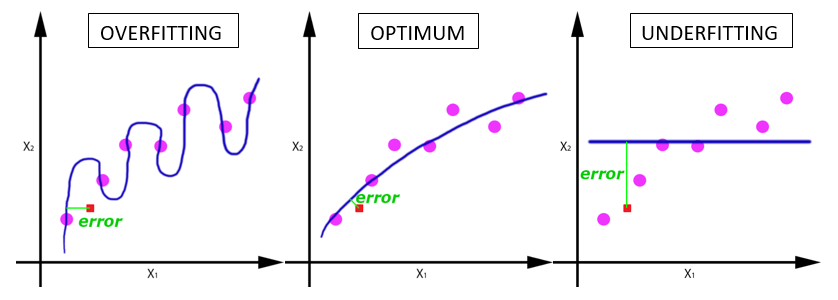

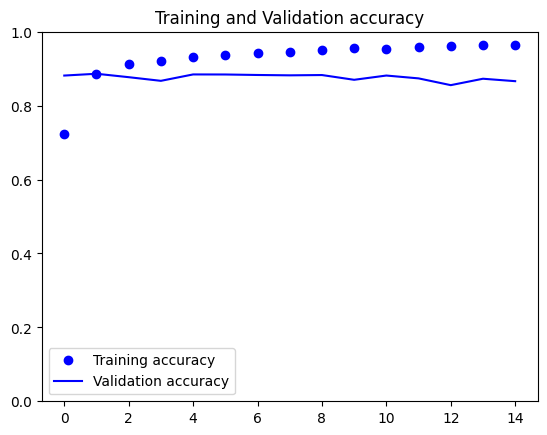

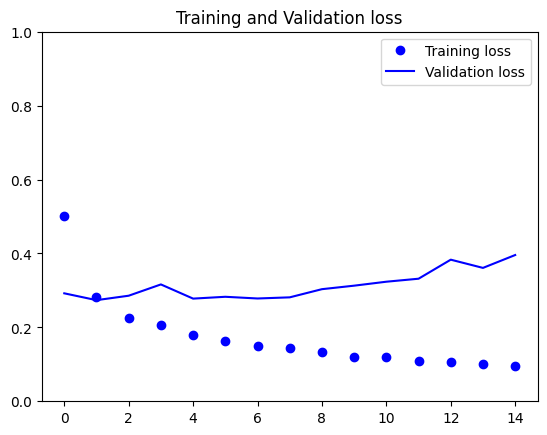

In [ ]:
accuracy = sentiment_train.history['accuracy']
val_accuracy = sentiment_train.history['val_accuracy']
loss = sentiment_train.history['loss']
val_loss = sentiment_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.ylim(0,1)
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylim(0,1)
plt.legend()
plt.show()

#Model Inferencing

In [ ]:
# Assuming test_X is your features and test_Y is your labels from the test set
# Let's randomly select an index
random_index = np.random.randint(0, len(test_X))

# Selecting a random sample from the test set
sample_features = np.expand_dims(test_X[random_index], axis=0)  # Model expects a batch dimension
sample_label = test_Y[random_index]

# Predicting the sentiment
prediction = sentiment_model.predict(sample_features)

# Interpreting the result
predicted_sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
actual_sentiment = 'Positive' if sample_label == 1 else 'Negative'

print(f'Predicted Sentiment: {predicted_sentiment}')
print(f'Actual Sentiment: {actual_sentiment}')

1/1 [==============================] - 3s 3s/step
Predicted Sentiment: Positive
Actual Sentiment: Positive


# Saving Model

In [ ]:
sentiment_model.save("Sentiment_Model.keras")

# Load Model

In [ ]:
sentiment_model = keras.models.load_model('/content/drive/MyDrive/Sentiment_Model.keras')